In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from sklearn.metrics import confusion_matrix
#version KNN ,SVC, GuassianNB
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing

#version KNN classifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier


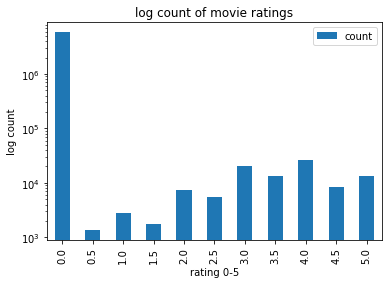

In [2]:
    ratings_path = "ml-latest-small/ratings.csv"
    movies_path = "ml-latest-small/movies.csv"
    movie_title = "Thor (2011)"
    
    df_movies = pd.read_csv(movies_path,usecols=['movieId','title'])
    df_ratings = pd.read_csv(ratings_path,usecols=['userId','movieId','rating'])
    df_movierating = pd.merge(df_ratings, df_movies, on='movieId')
    


Text(0, 0.5, 'Number of ratings')

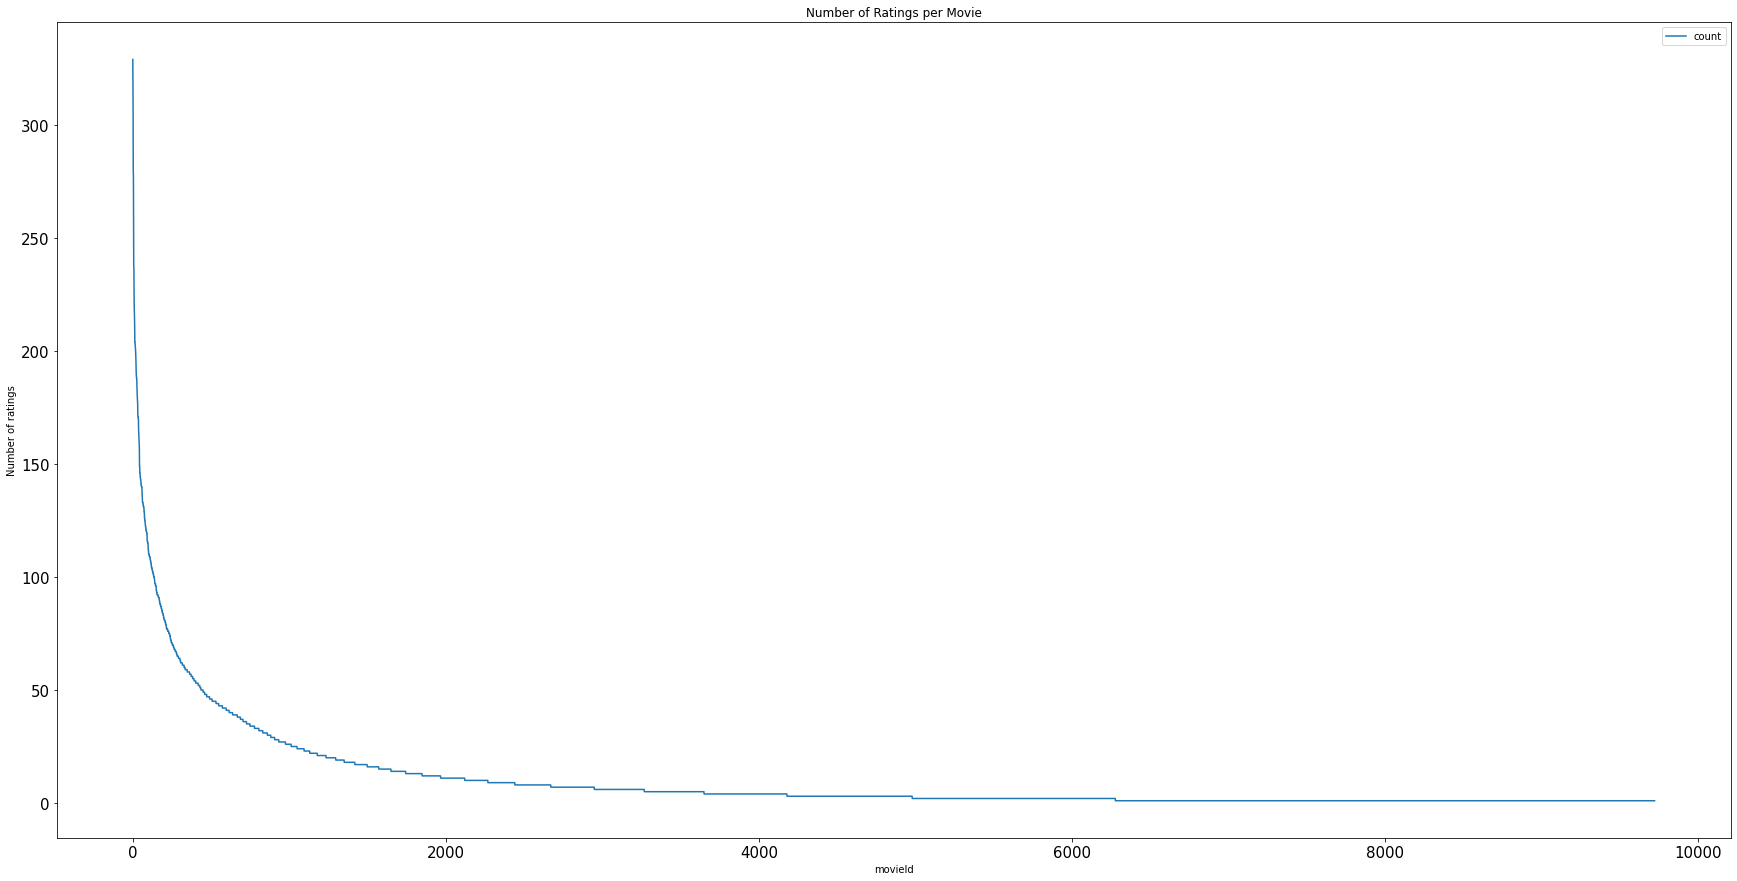

In [13]:
df_plt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_plt = df_plt.sort_values('count',ascending=False)
df_plt = df_plt.reset_index(drop=True)
plt1 = df_plt.plot(figsize=(30,15),fontsize=15)
plt1.set_xlabel("movieId")
plt1.set_ylabel("Number of ratings")
plt1.set_title("Number of Ratings per Movie")
plt1.get_figure()
fig.savefig('plot/ratingfq')

In [10]:
df_plt

,count
movieId,
356,329
318,317
296,307
593,279
2571,278
...,...
4093,1
4089,1
58351,1


In [3]:
def get_movie_idx_from_name(movie_title,movie_to_idx):
    for title,idx in movie_to_idx.items():
        if title == movie_title:
            return idx
    return None

In [29]:
def main():
    ratings_path = "ml-latest-small/ratings.csv"
    movies_path = "ml-latest-small/movies.csv"
    movie_title = "Thor (2011)"
    
    df_movies = pd.read_csv(movies_path,usecols=['movieId','title'])
    df_ratings = pd.read_csv(ratings_path,usecols=['userId','movieId','rating'])
    df_movierating = pd.merge(df_ratings, df_movies, on='movieId')
    
    df_plt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
    df_plt = df_plt.sort_values('count',ascending=False)
    df_plt = df_plt.reset_index(drop=True)
    plt1 = df_plt.plot(figsize=(10,5),fontsize=15)
    plt1.set_xlabel("movieId")
    plt1.set_ylabel("Number of ratings")
    plt1.set_title("Number of Ratings per Movie")
    plt1 = plt1.get_figure()
    plt1.savefig('plot/ratingfq')
    
    
    #--------------- item based recommender system ---------------#
    df_rating_mean = df_ratings.groupby(['movieId'],as_index = False, sort = False).mean()
    df_rating_mean = df_rating_mean.drop(columns=['userId'])
    df_rating_mean = df_rating_mean.rename(columns = {'rating': 'rating_mean'})
    df_rating_norm = pd.merge(df_rating_mean,df_ratings,on='movieId')
    df_rating_norm['rate_norm'] = df_rating_norm['rating']-df_rating_norm['rating_mean']
    df_movies2 = df_rating_mean.merge(df_movies,on='movieId')
    
    #-- reshape the data for indexing --#
    pivot = df_ratings.pivot(index='movieId',columns='userId', values = 'rating').fillna(0)
    csr_pivot = csr_matrix(pivot.values)

    movie_list = list(df_movies.set_index('movieId').loc[pivot.index].title)
    movie_to_idx = dict(map(lambda t: (t[1],t[0]), enumerate(movie_list))) #dictionary
    idx_to_movie = dict((v, k) for k, v in movie_to_idx.items()) # reverse dictionary
    
    idx = get_movie_idx_from_name(movie_title,movie_to_idx) # movie index
    
    #-- use machine learning (knn) to get closest movies to recommend --#
    knn_model_recommender = NearestNeighbors(metric='cosine',algorithm='brute',n_neighbors=20,n_jobs=-1)
    knn_model_recommender.fit(pivot)
    distances, indices = knn_model_recommender.kneighbors(csr_pivot[idx], n_neighbors=11)
    tuple_dist_idx = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]

    print('Recommendations for {} using a knn approach:'.format(movie_title))
    for i, (idx, dist) in enumerate(tuple_dist_idx):
        df_avg = df_movies2[df_movies2['title'] == idx_to_movie[idx]]
        avgr = round(df_avg, 3)
        print('{0}: {1}, with distance of {2} and average rating of {3}'.format(i+1, idx_to_movie[idx], dist, avgr['rating_mean'].iloc[0]))

    
    
    
    #---------------  machine learning ---------------#
    
    X_input = df_rating_norm[['movieId','userId']].values
    y_input = df_rating_norm['rate_norm'].values
    y_input = y_input.astype('int')
    X_train, X_test, y_train, y_test = train_test_split(X_input, y_input, test_size=0.3)


    #-- commenting out SVC because it takes too long to run, accuracy score for SVC is written in comment below --#
    X_scaled = preprocessing.scale(X_train) 
    Xtest_scaled = preprocessing.scale(X_test)
    svc_model =  SVC()
    svc_model.fit(X_scaled, y_train)
    y_predicted = svc_model.predict(Xtest_scaled)
    print("\nml model SVC")
    print(accuracy_score(y_test, y_predicted))   # 0.760760046015312
    
    bayes_model =  MultinomialNB()
    bayes_model.fit(X_train, y_train)
    y_predicted = bayes_model.predict(X_test)
    print("\n ml model MultinomialNB")
    print(accuracy_score(y_test, y_predicted))  # 0.044858021222438926

    knnc_model = KNeighborsClassifier(n_neighbors=5)
    knnc_model.fit(X_train, y_train)
    y_predicted = knnc_model.predict(X_test)
    print("\n ml model KNN Classifier")
    print(accuracy_score(y_test, y_predicted)) #  0.7298601699117384
    
    gnb_model =  GaussianNB()
    gnb_model.fit(X_train, y_train)
    y_predicted = gnb_model.predict(X_test)
    print("\n ml model Gaussian NB")
    print(accuracy_score(y_test, y_predicted)) #  0.7639416878780867
 

Recommendations for Thor (2011) using a knn approach:
1: Iron Man 2 (2010), with distance of 0.4122386705030212 and average rating of 3.511
2: Iron Man (2008), with distance of 0.4105084379024724 and average rating of 3.824
3: Guardians of the Galaxy (2014), with distance of 0.40524208122988714 and average rating of 4.051
4: Avengers, The (2012), with distance of 0.3857602802793373 and average rating of 3.87
5: X-Men: Days of Future Past (2014), with distance of 0.3827783789057232 and average rating of 3.833
6: X-Men: First Class (2011), with distance of 0.3770012123772253 and average rating of 3.791
7: Incredible Hulk, The (2008), with distance of 0.3624631782287856 and average rating of 3.171
8: Avengers: Age of Ultron (2015), with distance of 0.35893484809667464 and average rating of 3.519
9: Thor: The Dark World (2013), with distance of 0.3347264936073989 and average rating of 3.31
10: Captain America: The First Avenger (2011), with distance of 0.25210325869083205 and average ratin

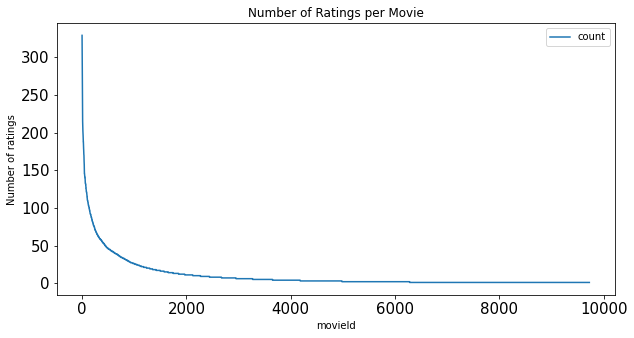

In [30]:
if __name__ == '__main__':
    main()